# Task 1 - Classification Model
## 1. Data Filtering and Data Visualization:
- Extract the entries corresponding to your home state from the dataset. Ensure you accurately filter out only those pincodes that belong to your home state.
- You can utilize the longitude and latitude data to plot the geographical locations of these pincodes on a map (get creative!). This will help in visualizing the distribution of the pincodes across your state.
### Answer:
The following code filters out the data which belong to my home state i.e., Telangana. Since Telangana has latitude and longitude are in ranges (15,20), (76,82) respectively, any other data point is removed. Also the duplicates and some missing ones are also removed. save it into data.csv. We also arrange them based on their pincodes and then plot them to visualise.

   Unnamed: 0        CircleName             RegionName  \
0      130591  Telangana Circle  Hyderabad City Region   
1      126871  Telangana Circle  Hyderabad City Region   
2      126870  Telangana Circle  Hyderabad City Region   
3      124355  Telangana Circle  Hyderabad City Region   
4      131920  Telangana Circle  Hyderabad City Region   

                    DivisionName                   OfficeName  Pincode  \
0         Hyderabad GPO Division             Hyderabad G.P.O.   500001   
1        Hyderabad City Division  State Bank Of Hyderabad S.O   500001   
2        Hyderabad City Division             Seetharampet S.O   500001   
3        Hyderabad City Division              Moazzampura S.O   500001   
4  Hyderabad South East Division                 Charminar HO   500002   

  OfficeType      Delivery   District  StateName   Latitude  Longitude  
0         HO      Delivery  HYDERABAD  TELANGANA  17.393139  78.476278  
1         PO  Non Delivery  HYDERABAD  TELANGANA  17.662250 

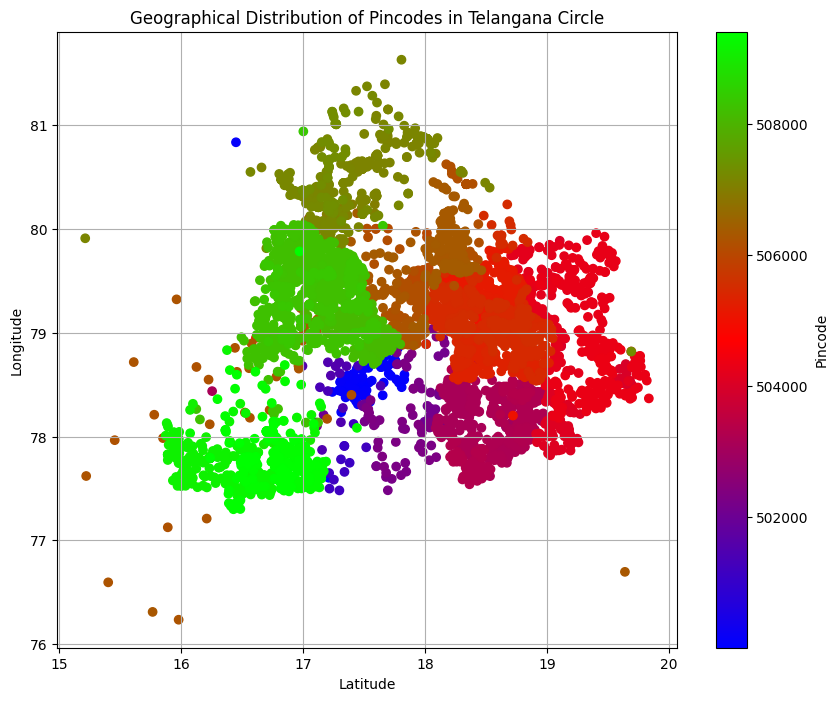

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the dataset with low_memory=False to avoid the DtypeWarning
data = pd.read_csv('clustering_data.csv', low_memory=False)

# Filter the dataset for the home state
home_state = 'Telangana Circle'  # Correct value for your home state
filtered_data = data[data['CircleName'] == home_state]

# Convert Latitude and Longitude to numeric, coercing errors
filtered_data['Latitude'] = pd.to_numeric(filtered_data['Latitude'], errors='coerce')
filtered_data['Longitude'] = pd.to_numeric(filtered_data['Longitude'], errors='coerce')

# Drop rows with NaN values in Latitude or Longitude
filtered_data = filtered_data.dropna(subset=['Latitude', 'Longitude'])

# Convert Pincode to numeric, coercing errors
filtered_data['Pincode'] = pd.to_numeric(filtered_data['Pincode'], errors='coerce')

# Remove duplicate rows based on all columns
filtered_data = filtered_data.drop_duplicates(subset=['Latitude', 'Longitude'])

# Sort data by Pincode
filtered_data = filtered_data.sort_values(by='Pincode')

# Normalize pincodes to range [0, 1] for colormap
norm = plt.Normalize(filtered_data['Pincode'].min(), filtered_data['Pincode'].max())
colors = plt.cm.brg(norm(filtered_data['Pincode']))

# Create a ScalarMappable to correctly associate colormap with colorbar
sm = plt.cm.ScalarMappable(cmap='brg', norm=norm)
sm.set_array([])  # Need an empty array to correctly plot the colorbar

# Remove rows where Latitude is less than 15 or greater than 20
# and Longitude is less than 76 or greater than 82
filtered_data = filtered_data[(filtered_data['Latitude'] >= 15) & (filtered_data['Latitude'] <= 20) & (filtered_data['Longitude'] >= 76) & (filtered_data['Longitude'] <= 82)]

filtered_data.to_csv('data.csv')

print(pd.read_csv('data.csv').head())
# Normalize pincodes to range [0, 1] for colormap again after filtering
norm = plt.Normalize(filtered_data['Pincode'].min(), filtered_data['Pincode'].max())
colors = plt.cm.brg(norm(filtered_data['Pincode']))

# Plot the geographical locations
plt.figure(figsize=(10, 8))
plt.scatter(filtered_data['Latitude'], filtered_data['Longitude'], c=colors, marker='o')
plt.title(f'Geographical Distribution of Pincodes in {home_state}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid(True)
plt.colorbar(sm, label='Pincode', ax=plt.gca())
plt.show('map.png')

#### Observations and some information about pincode:
We observe that pincodes of same zone have close colors and of same district are even closer. This is because the 2nd and 3rd digits of pincode does correspond to zones and districts of the state. The last two digits represent the delivery office within the sorting district starting from "01" which would be the General Post Office (GPO) or head office (HO). The numbering of the delivery office is done chronologically with higher numbers assigned to newer delivery offices. So from the plot we can also get information about the old and new delivery offices within a district.
If the volume of mail handled at a delivery office is too large, a new delivery office is created and the next available PIN is assigned. Thus, two delivery offices situated next to each other will only have the first four digits in common. Each PIN is mapped to exactly one delivery post office which receives all the mail to be delivered to one or lower offices within its jurisdiction, all of which share the same code. The delivery office can either be a General Post Office (GPO), a head office (HO), or a sub-office (SO) which are usually located in urban areas. Because of this, I didn't filter out the points which share the same pincode. The post from the delivery office is sorted and routed to other delivery offices for a different PIN or to one of the relevant sub-offices or branch offices for the same PIN.

## 2. Clustering Analysis:
- Implement the k-means clustering algorithm from scratch (do not use any pre-built k-means function).
- Apply this algorithm to the longitude and latitude data of your filtered pincodes to identify distinct clusters within your state.
### Answer:
#### K-means algorithm:
This algorithm is used to sort out k clusters from a big data of points. It is done in following way:
1. Choose k centroids randomly
2. Assign the points to the nearest centroid and make it a group. So we get k groups
3. Calculate the mean of each group and make it the new centroid.
4. Repeat step 2,3 till the mean of group and old centroid match.

In this way, it makes k clusters.
#### K-means++ algorithm:
The choice of centroids is random in k-means algorithm. If centroids are chosen too close, we might not get expected results. So, we can use k-means++ algorithm to get centroids which are relatively far from each other and is not as random as general k-means algorithm. The steps are as follows:
1. Choose 1st centroid randomly
2. Calculate distance of each point from nearest centroid
3. Next centroid is the data point which is at maximum distance from nearest centroid(which are already chosen).
4. Repeat step 2 and 3 till k centroids are chosen.

The following code uses the above algorithms for k=3, k=7 and plot them.

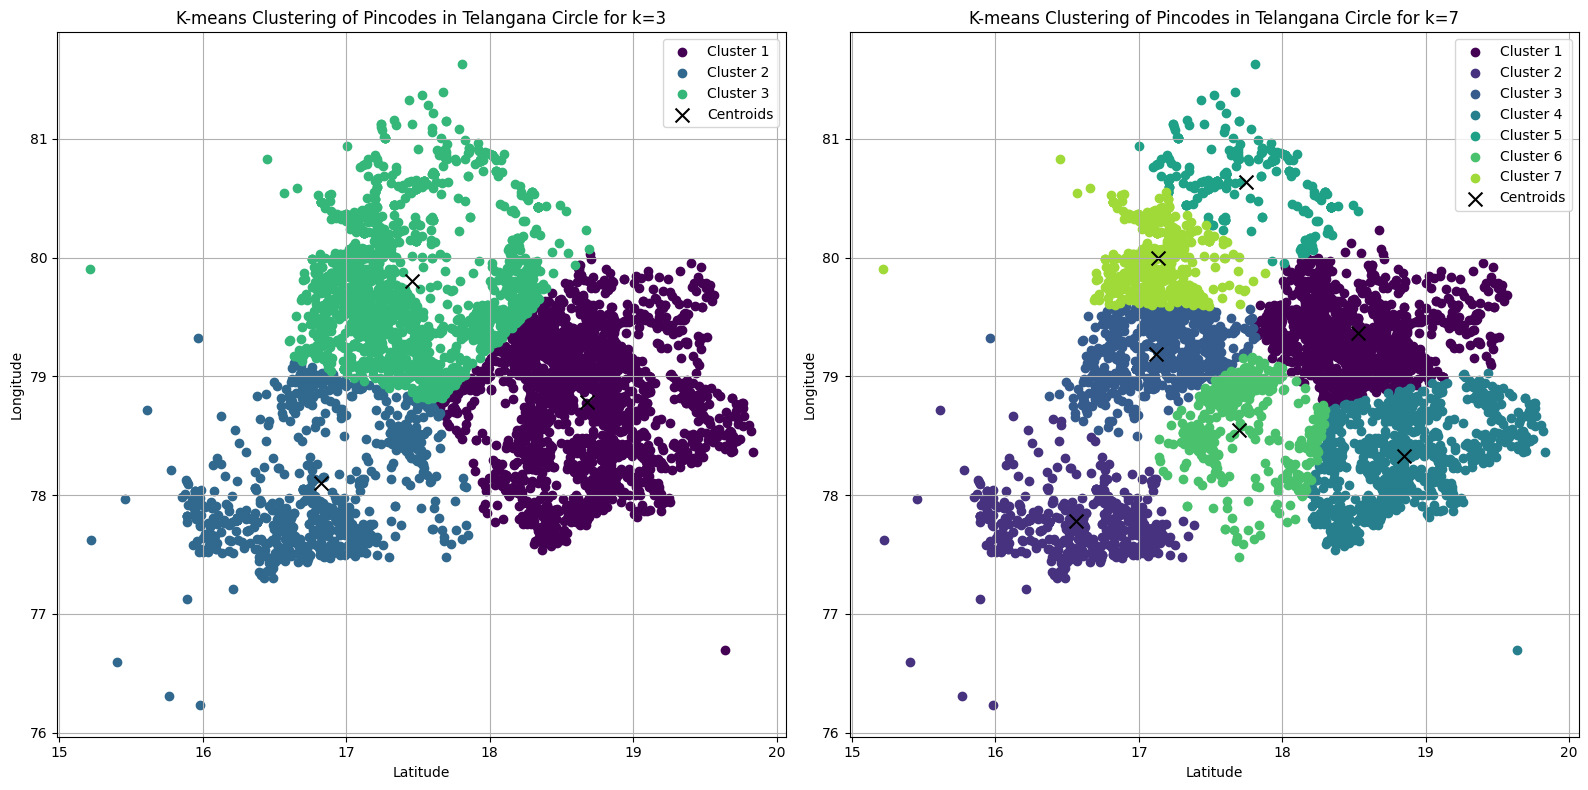

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Define a function to calculate the distance between two points
def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def k_means_plus_plus_initialization(data, k):
    n_samples, _ = data.shape
    centroids = np.empty((k, data.shape[1]))

    # Initialize the first centroid randomly
    centroids[0] = data[np.random.randint(0, n_samples)]

    # Initialize the remaining centroids
    for i in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c) for c in centroids[:i]]) for x in data])
        centroids[i] = data[distances.argmax()]

    return centroids

# Define the k-means clustering algorithm
def k_means_clustering(data, k, max_iterations=100):
    # Initialize centroids
    centroids = k_means_plus_plus_initialization(data, k)
    for i in range(max_iterations):
        # Assign each point to the nearest centroid
        clusters = [[] for j in range(k)]
        for point in data:
            distances = [calculate_distance(point, centroid) for centroid in centroids]
            cluster_index = np.argmin(distances)
            clusters[cluster_index].append(point)
        
        # Update centroids
        new_centroids = np.array([np.mean(cluster, axis=0) for cluster in clusters])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, clusters

# Load the dataset with low_memory=False to avoid the DtypeWarning
data = pd.read_csv('data.csv', low_memory=False)

# Extract Longitude and Latitude data
coordinates = data[['Latitude', 'Longitude']].values

# Apply k-means clustering
# Define the number of clusters
ks = [3, 7]

# Create subplots for each k value
plt.figure(figsize=(16, 8))
idx = 0
for k in ks:
    centroids, clusters = k_means_clustering(coordinates, k)
    plt.subplot(1, 2, idx + 1)
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        plt.scatter(cluster[:, 0], cluster[:, 1], color=plt.cm.viridis(i/k), label=f'Cluster {i+1}')
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
    plt.title(f'K-means Clustering of Pincodes in {home_state} for k={k}')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()
    plt.grid(True)
    idx=idx+1

plt.tight_layout()
plt.show()


## 3. Inference and Insights:
- Draw meaningful inferences from your clustering results. Analyze the characteristics of the clusters you identified and provide insights about the geographical distribution and potential implications.
### Answer:
- I have plotted for k=7 since there are 7 subzones in Telangana. This clustering data looks close to subzones of Telangana too. Also the 2nd digit of pincode represents the subzone of the state, we can observe that the two plots have some similarity.
- I have plotted for k=3 because we get elbow point at 3 when we plot the SSE(Sum of Squared Errors) vs k. Refer the following code and plot.


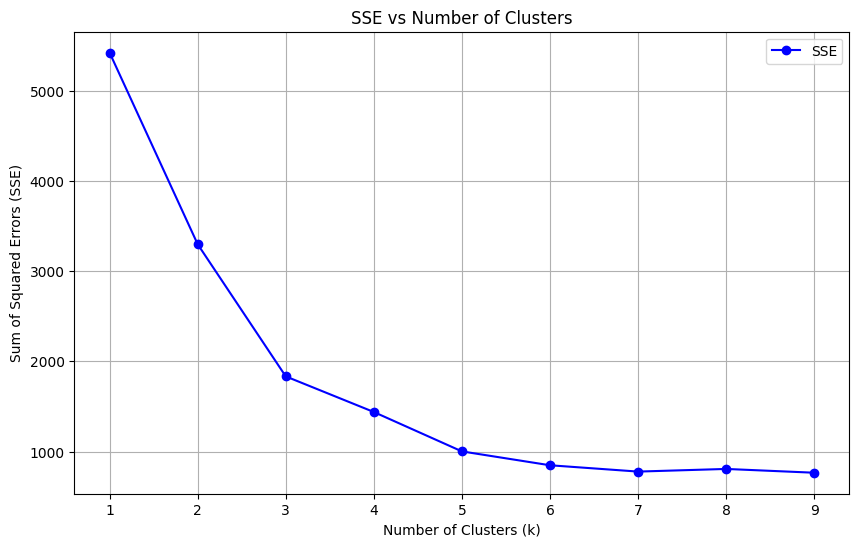

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Define a function to calculate the distance between two points
def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def k_means_plus_plus_initialization(data, k):
    n_samples, _ = data.shape
    centroids = np.empty((k, data.shape[1]))

    # Initialize the first centroid randomly
    centroids[0] = data[np.random.randint(0, n_samples)]

    # Initialize the remaining centroids
    for i in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c) for c in centroids[:i]]) for x in data])
        centroids[i] = data[distances.argmax()]

    return centroids

# Define the k-means clustering algorithm
def k_means_clustering(data, k, max_iterations=100):
    # Initialize centroids
    centroids = k_means_plus_plus_initialization(data, k)
    for i in range(max_iterations):
        # Assign each point to the nearest centroid
        clusters = [[] for j in range(k)]
        for point in data:
            distances = [calculate_distance(point, centroid) for centroid in centroids]
            cluster_index = np.argmin(distances)
            clusters[cluster_index].append(point)
        
        # Update centroids
        new_centroids = np.array([np.mean(cluster, axis=0) for cluster in clusters])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    # Calculate SSE
    sse = 0
    for i, centroid in enumerate(centroids):
        sse += np.sum((np.array(clusters[i]) - centroid) ** 2)
    
    return centroids, clusters, sse

# Load the dataset with low_memory=False to avoid the DtypeWarning
data = pd.read_csv('data.csv', low_memory=False)

# Extract Longitude and Latitude data
coordinates = data[['Latitude', 'Longitude']].values

# Apply k-means clustering
k_values = np.arange(1, 10)  # Array of number of clusters
sse_values = []

for k in k_values:
    _, _, sse = k_means_clustering(coordinates, k)
    sse_values.append(sse)

# Plot SSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse_values, marker='o', linestyle='-', color='b', label='SSE')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('SSE vs Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()